###Trying SVC & Log-LassoClassifiers:

In [216]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [185]:
#this data set has: i) candidate info; ii) movable assets; iii) immovable assets
assets_df=pd.read_csv("assets_df.csv")

In [186]:
assets_df.drop('Unnamed: 0_x', axis=1, inplace=True)
assets_df.drop('Unnamed: 0', axis=1, inplace=True)
assets_df.drop('Unnamed: 0.1', axis=1, inplace=True)

In [187]:
assets_df.head(1)

,"Bonds, Debentures and Shares in companies",Cash,"Deposits in Banks, Financial Institutions and Non-Banking Financial Companies",Gross Total Value (as per Affidavit),Jewellery (give details weight value),LIC or other insurance Policies,"Motor Vehicles (details of make, etc.)","NSS, Postal Savings etc","Other assets, such as values of claims / interests",Personal loans/advance given,TOTAL_MOVABLE_ASSESTS,Totals (Calculated as Sum of Values),url,year_x,winner,location,state,Age,Assets_Rs,Constituency,Criminal_Cases,Education,Liabilities_Rs,Link,Name,Party,State,Agricultural Land,Commercial Buildings,Non Agricultural Land,Others,Residential Buildings,TOTAL_IMMOVABLE_ASSESTS,Total Current Market Value of (i) to (v) (as per Affidavit),year_y
0,NaN,70500,1519565,NaN,128501,350000,410000,316155,621439,NaN,3416160,3066160,http://myneta.info/loksabha2004/candidate.php?...,2004,1,Andaman & Nicobar Islands (ANDAMAN & NICOBAR ...,ANDAMAN & NICOBAR ISLANDS,65,5926740,Andaman & Nicobar Islands,0,Post Graduate,272061,candidate.php?candidate_id=1,MANORANJAN BHAKTA,INC,ANDAMAN & NICOBAR ISLANDS,846000,NaN,64580,NaN,1950000,2860580,NaN,2004


#####Step 1: Log-transform income data

In [188]:
assets_df=assets_df.replace(np.NaN,0.0)

In [204]:
assets_df=assets_df.replace('NATIONAL CAPITAL TERRITORY OF DELHI','DELHI')

/Users/anneshrestha/anaconda/lib/python2.7/site-packages/pandas/core/common.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [205]:
#list(assets_df.columns)

In [206]:
logcols=list(assets_df.columns)
non_assest=('Gross Total Value (as per Affidavit)','url','year_x','winner','location','state','Age',
            'Assets_Rs','Constituency','Criminal_Cases','Education','Liabilities_Rs','Link','Name','Party','State','year_y',
            'Total Current Market Value of (i) to (v) (as per Affidavit)','Totals (Calculated as Sum of Values)')

In [207]:
for i in non_assest:
    try:
        logcols.remove(i)
    except:
        print i
print len(logcols)

16


Remove observations with zero total assets. 
Treat tables where immovable assets=0 as missing data since it's not credible that candidates have zero cash; they must have avoided reporting altogether...

In [226]:
#remove tables where total assests report including cash=0
nonempty=assets_df[(assets_df['TOTAL_MOVABLE_ASSESTS']!=0)]
count_nonempty=len(nonempty.TOTAL_MOVABLE_ASSESTS)
count_all=len(assets_df.TOTAL_MOVABLE_ASSESTS)
print count_all-count_nonempty

2155


In [227]:
#log transofrm asset info:
for st in logcols:
    nonempty[st]=np.log(nonempty[st]+1)

/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


#####Step 2: Standardize all the columns
In this step all the features will be normalized with zero mean and unit standard deviation.

In [228]:
#create codes for categorical variables:

categorical = ['Constituency','Education','Party','State']
for c in categorical:
    le = LabelEncoder().fit(nonempty[c])
    nonempty[c]=le.transform(nonempty[c])

/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [229]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(nonempty.shape[0]), train_size=0.8)

In [238]:
mask=np.ones(nonempty.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [239]:
#list(nonempty.columns)

In [241]:
%%time
#this was taking very long. Ideally we should do this on a fast computer and save the data.

dftrain=nonempty[mask]

numeric = logcols + ['Criminal_Cases']

std_scale = StandardScaler().fit(dftrain[numeric])
#enc = OneHotEncoder().fit(dftrain[categorical])

nonempty[numeric] = std_scale.transform(nonempty[numeric])
#categorical_vars = enc.transform(nonempty[categorical]).toarray()

#standarized = []
#for x,y in zip(numeric_vars, categorical_vars):
#    standarized.append(np.concatenate([x,y]))
#    std_df = pd.DataFrame(standarized)

#std_df.head(1)

CPU times: user 3.47 s, sys: 46.8 ms, total: 3.52 s
Wall time: 4.11 s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


####Classifiers

#####SVM Classifier:

We test out support vector machine with class weight for our asymmetric data set. As SVMs work best with rather balanced data sets, we will sub-sample our data in the next section of this notebook.

In [242]:
from sklearn.svm import SVC

In [243]:
clfsvm=SVC()
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=nonempty[numeric].values
Yresp=nonempty['winner'].values

In [244]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [340]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, make_scorer, accuracy_score
from sklearn.grid_search import GridSearchCV

The following three functions `cv_optimize`,`do_classify` and `make_roc` are adapted versions of hw and lab codes. 

`cv_optimize` uses `roc_auc_score` scoring system inside the `GridSearchCV` cross-validation loop in order to optimize based on AUC instead of accuracy score, which are less relevant in highly unbalanced data.

See comments in the codes for additional information.



In [353]:
def cv_optimize(clf, parameters, X, y, n_folds=5):
    
    #created scoring option to add different types of scorers for cross-validation:
    
    score_fx=make_scorer(roc_auc_score,greater_is_better=True)
    
    #change scoring to 'None' for standard accuracy within grid search:
    
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_fx)
    gs.fit(X, y)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

#code help from hw3

In [ ]:

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test__accuracy = clf.score(Xtest, ytest)
    print "Based on standard predict::"
    print "  Accuracy on training data: %0.2f" % (training_accuracy)
    print "  Acurracy on test data:     %0.2f" % (test__accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "_______________________________"
    return clf, Xtrain, ytrain, Xtest, ytest

#code from hw3
# removed scoring function option in both functions and embedded it make_scorer feature wth roc_auc_scorer

In [365]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

#from lab 6

In [431]:
print "winners in whole data set", nonempty['winner'].mean()
print "winners in training set", nonempty['winner'][mask].mean()
print "winners in test set", nonempty['winner'][~mask].mean()

winners in whole data set 0.0774486129925
winners in training set 0.0784068320695
winners in test set 0.0736160188457


Initially, we used the default `SVC()`option with accuracy score based grid-search optimization to select hyper-parameters. The following result shows that the separating hyperplane is based on support vectors that are at the edge of the data. That is, the hyperplane assumes all losses and the SVM is as good as a random guess based on all losses. 

In [352]:
%%time
#THIS ONE IS USING ACCURACY WITHIN THE GRIDSEARCH:
#DO NOT RERUN- SCORING ADJUSTED IN FUNCTION INVARIABLY!

#tried class class_weights={1:10}; results = same as before; didnt' work
#tried class class_weights='auto'; results = same as before; didnt' work
#adding gamma parameter options; gamma refers to the length of the maximum margin between the hyperplane and support vectors
#(C is inversely related to the "leniency" of the classifier)

clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), 
                                                   {"C": [ 10, 1, 0.1, 0.01,0.001,0.0001,0.00001 ]}, 
                                                   nonempty,featurenames=logcols, targetname='winner',target1val=1, mask=mask)

using mask
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.92
  Acurracy on test data:     0.93
[[3146    0]
 [ 250    0]]
_______________________________
CPU times: user 1min 53s, sys: 2.15 s, total: 1min 55s
Wall time: 2min 7s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


To account for the imbalance in the dataset, we change the optimization parameters in the `cv_optimize` function. The hyper-parameters for the model is now selected based on the maximization of area-under-the-curve (AUC), based on true-positive and false negative rates. 

This yields a better result, with both high accuracy score but a non-isolated hyperplane.

In [374]:
%%time
#THIS ONE IS USING ROC_AUC_SCORER WITHIN GRIDSEARCH:
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), 
                                                   {"C": [20,15,10, 1, 0.1, 0.01,0.001,0.0001]}, 
                                                   nonempty,featurenames=logcols, targetname='winner',target1val=1, mask=mask)

using mask
BEST PARAMS {'C': 20}
Based on standard predict::
  Accuracy on training data: 0.95
  Acurracy on test data:     0.91
[[3070   76]
 [ 225   25]]
_______________________________
CPU times: user 2min 58s, sys: 2.87 s, total: 3min 1s
Wall time: 3min 32s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


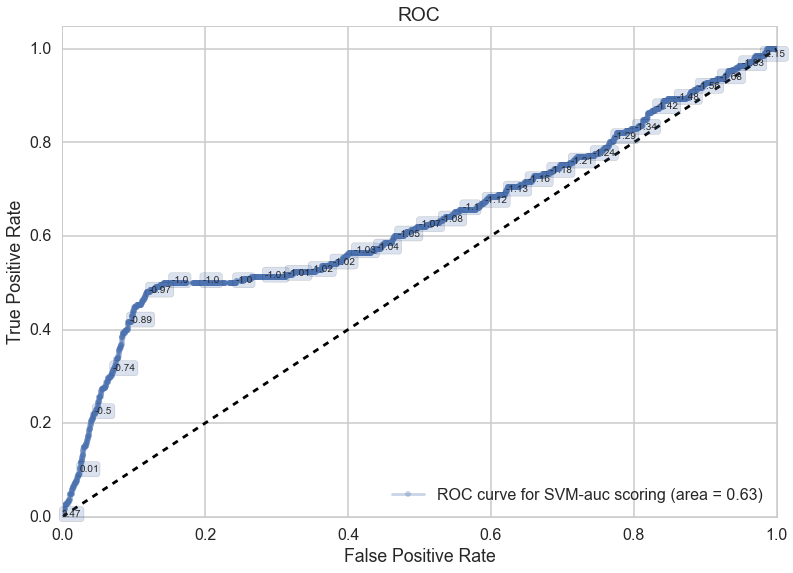

In [375]:
ax=make_roc("SVM-auc scoring", clfsvm, ytest, Xtest, proba=False, labe=100)

In [372]:
%%time
#try with class-weight to deal with imbalance (http://scikit-learn.org/stable/modules/svm.html):
clfsvm1, Xtrain1, ytrain1, Xtest1, ytest1 = do_classify(SVC(class_weight='auto'), 
                                                   {"C": [ 100,20,15,10, 1, 0.1, 0.01,0.001,0.0001]}, 
                                                   nonempty,featurenames=logcols, targetname='winner',target1val=1, mask=mask)

using mask
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.74
  Acurracy on test data:     0.73
[[2264  882]
 [  37  213]]
_______________________________
CPU times: user 7min 39s, sys: 7.68 s, total: 7min 47s
Wall time: 8min 57s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


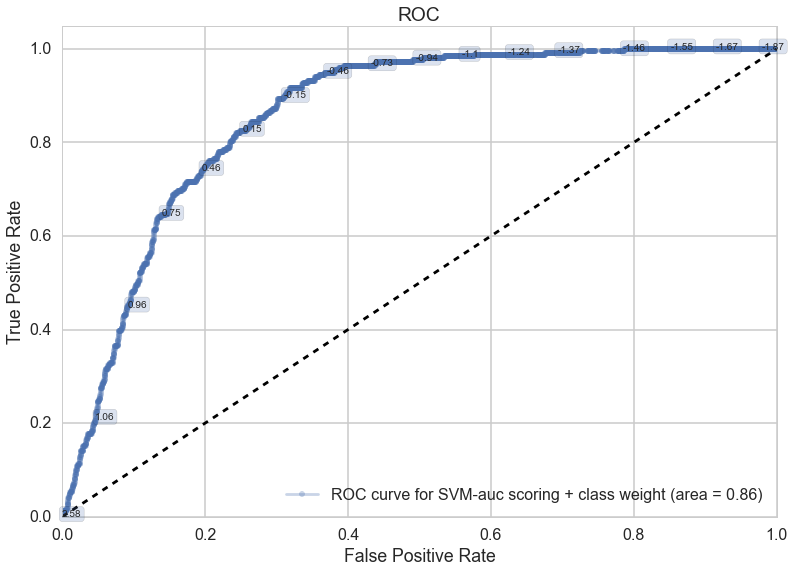

In [373]:
ax=make_roc("SVM-auc scoring + class weight", clfsvm1, ytest1, Xtest1, proba=False, labe=200)

In [ ]:
fit_params={'sample_weight': sw_train}

(array([ 410.,  400.,  404.,  412.,  352.,  323.,  330.,  381.,  305.,   79.]),
 array([ 0.22904636,  0.305041  ,  0.38103564,  0.45703029,  0.53302493,
         0.60901957,  0.68501422,  0.76100886,  0.8370035 ,  0.91299815,
         0.98899279]),
 <a list of 10 Patch objects>)

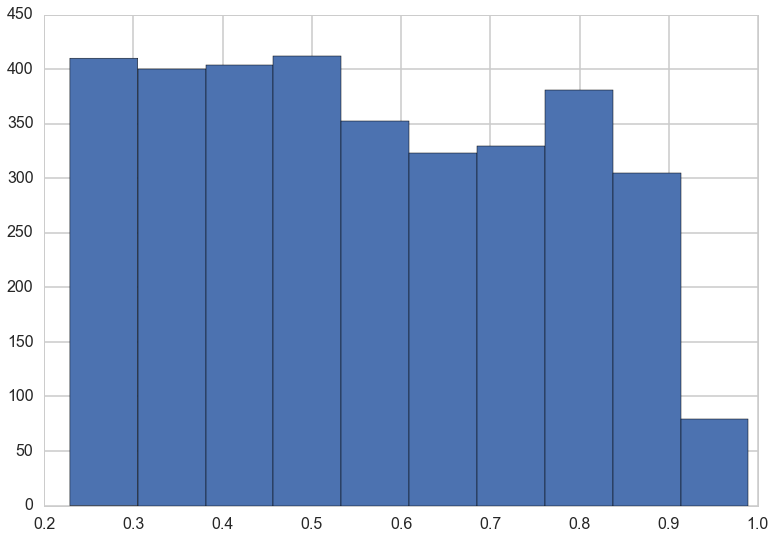

In [302]:
plt.hist(clfsvm.decision_function(Xtest))

In [282]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

#####Log-Lasso Classifier:
penalty l1 = lasso regularization

In [391]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty="l1")
parameters = {"C": [0.01,0.001,0.0001,0.00001,0.000001,0.0000001, 0.1, 1, 10, 100]}
clflog, Xtrainl, ytrainl, Xtestl, ytestl = do_classify(clf,parameters, nonempty,logcols, 'winner',0, reuse_split=reuse_split)


using reuse split
BEST PARAMS {'C': 10}
Based on standard predict::
  Accuracy on training data: 0.92
  Acurracy on test data:     0.92
[[3116   30]
 [ 240   10]]
_______________________________


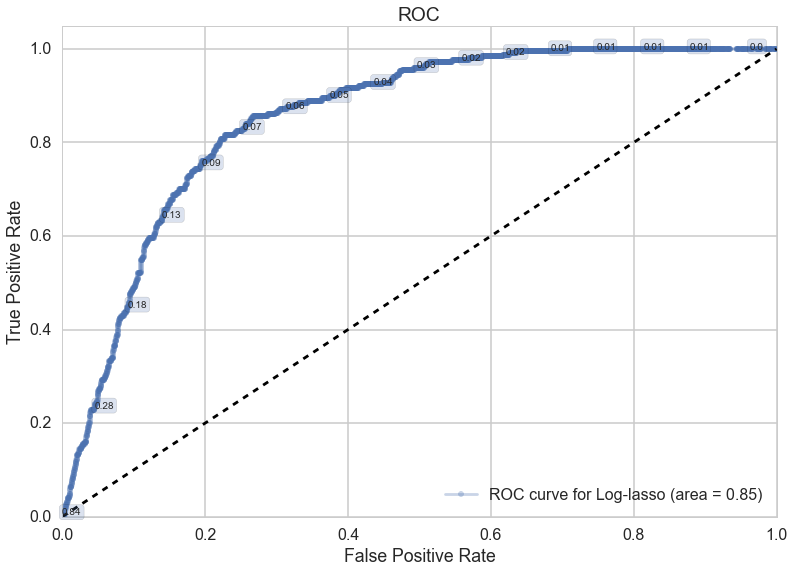

In [392]:
ax=make_roc("Log-lasso", clflog, ytestl, Xtestl, proba=True, labe=200)

([array([  0.00000000e+00,   1.00000000e+00,   7.00000000e+00,
           1.60000000e+01,   1.60000000e+01,   4.10000000e+01,
           8.70000000e+01,   1.89000000e+02,   4.07000000e+02,
           2.63200000e+03]),
  array([  2.63200000e+03,   4.07000000e+02,   1.89000000e+02,
           8.70000000e+01,   4.10000000e+01,   1.60000000e+01,
           1.60000000e+01,   7.00000000e+00,   1.00000000e+00,
           0.00000000e+00])],
 array([  9.78358612e-04,   1.00782687e-01,   2.00587015e-01,
          3.00391343e-01,   4.00195672e-01,   5.00000000e-01,
          5.99804328e-01,   6.99608657e-01,   7.99412985e-01,
          8.99217313e-01,   9.99021641e-01]),
 <a list of 2 Lists of Patches objects>)

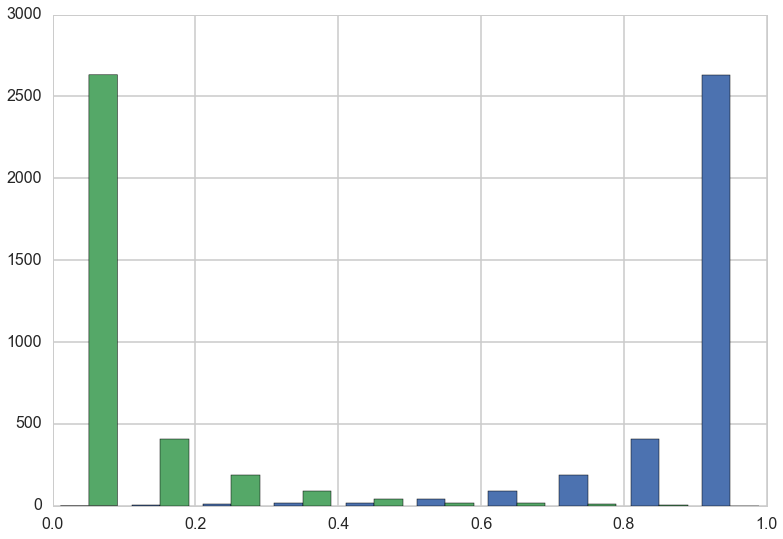

In [364]:
plt.hist(clflog.predict_proba(Xtest))

In [389]:
clf_c = LogisticRegression(penalty="l1",class_weight='auto')
parameters = {"C": [0.01,0.001,0.0001,0.00001,0.000001,0.0000001, 0.1, 1, 10, 100]}
clflog_c, Xtrain_c, ytrain_c, Xtest_c, ytest_c = do_classify(clf,parameters, nonempty,logcols, 'winner',0, reuse_split=reuse_split)

using reuse split
BEST PARAMS {'C': 1}
Based on standard predict::
  Accuracy on training data: 0.78
  Acurracy on test data:     0.78
[[2453  693]
 [  55  195]]
_______________________________


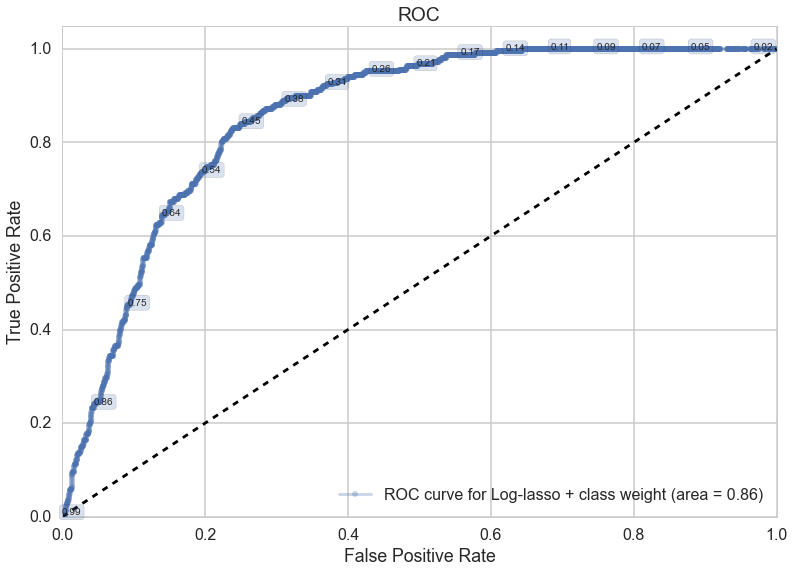

In [390]:
ax=make_roc("Log-lasso + class weight", clflog_c, ytest_c, Xtest_c, proba=True, labe=200)

####Let's try using a subsample of the data to train the SVM on a balaced data:

##### Running the two classifiers on a balanced train set:

In [404]:
jtrain=np.arange(0, ytrain.shape[0])
n_win=len(jtrain[ytrain==1])
n_los=len(jtrain[ytrain==0])
print n_win, n_los

1065 12518


In [405]:
ilos = np.random.choice(jtrain[ytrain==0], n_win, replace=False)

In [406]:
alli=np.concatenate((jtrain[ytrain==1], ilos))
alli.shape

(2130,)

In [387]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((2130, 16), (2130,))

In [388]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

In [394]:
clflog_b, Xtrain_b, ytrain_b, Xtest_b, ytest_b  = do_classify(clf, {"C": [0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, nonempty,logcols, 'winner',1, reuse_split=reuse_split_new)

using reuse split
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.80
  Acurracy on test data:     0.77
[[2423  723]
 [  48  202]]
_______________________________


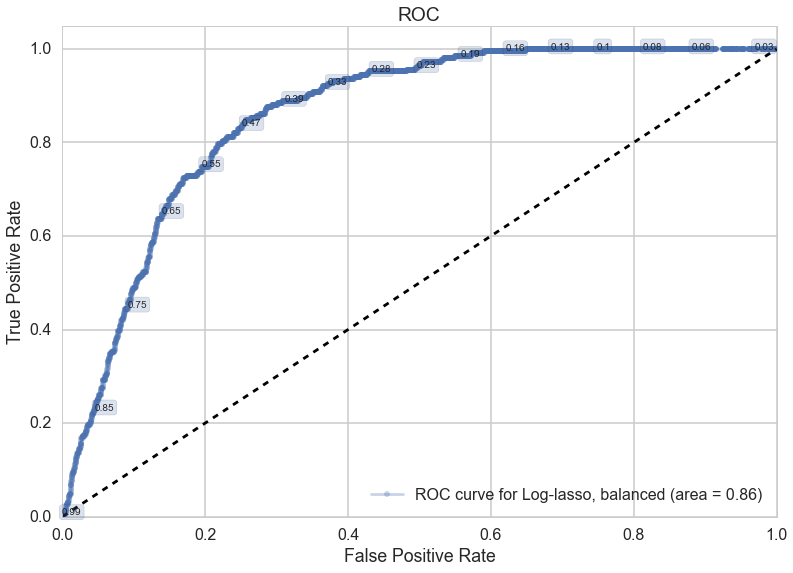

In [396]:
ax=make_roc("Log-lasso, balanced", clflog_b, ytest_b, Xtest_b, proba=True, labe=200)

In [402]:
clfsvm_b, Xtrainb, ytrainb, Xtestb, ytestb = do_classify(SVC(), {"C": [0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, nonempty,logcols, 'winner',1, reuse_split=reuse_split_new)

using reuse split
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.81
  Acurracy on test data:     0.72
[[2227  919]
 [  38  212]]
_______________________________


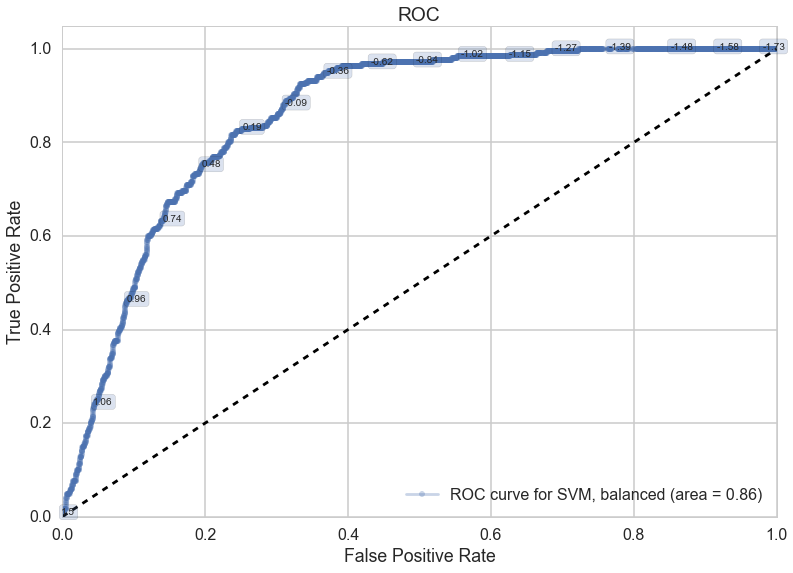

In [429]:
ax=make_roc("SVM, balanced", clfsvm_b, ytestb, Xtestb, proba=False, labe=200)

In [383]:
#clear unused data from working memory 
import gc
gc.collect()

4762

#### Train with partially balanced dataset; 2/3 losers and 1/3 winners:

In [407]:
ilos_pb = np.random.choice(jtrain[ytrain==0], n_win*2, replace=False)

In [408]:
alli_pb=np.concatenate((jtrain[ytrain==1], ilos_pb))
alli_pb.shape

(3195,)

In [409]:
Xtrain_pb = Xtrain[alli_pb]
ytrain_pb = ytrain[alli_pb]
Xtrain_pb.shape, ytrain_pb.shape

((3195, 16), (3195,))

In [410]:
reuse_split_pb=dict(Xtrain=Xtrain_pb, Xtest=Xtest, ytrain=ytrain_pb, ytest=ytest)

In [419]:
clflog_pb,Xtrain_pb, ytrain_pb, Xtest_pb, ytest_pb = do_classify(clf, {"C": [0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}, nonempty,logcols, 'winner',1, reuse_split=reuse_split_pb)

using reuse split
BEST PARAMS {'C': 0.01}
Based on standard predict::
  Accuracy on training data: 0.79
  Acurracy on test data:     0.85
[[2746  400]
 [ 116  134]]
_______________________________


In [420]:
clfsvm_pb, Xtrainpb, ytrainpb, Xtestpb, ytestpb = do_classify(SVC(), 
                               {"C": [0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}, nonempty,logcols, 'winner',1, reuse_split=reuse_split_pb)

using reuse split
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.81
  Acurracy on test data:     0.82
[[2605  541]
 [  76  174]]
_______________________________


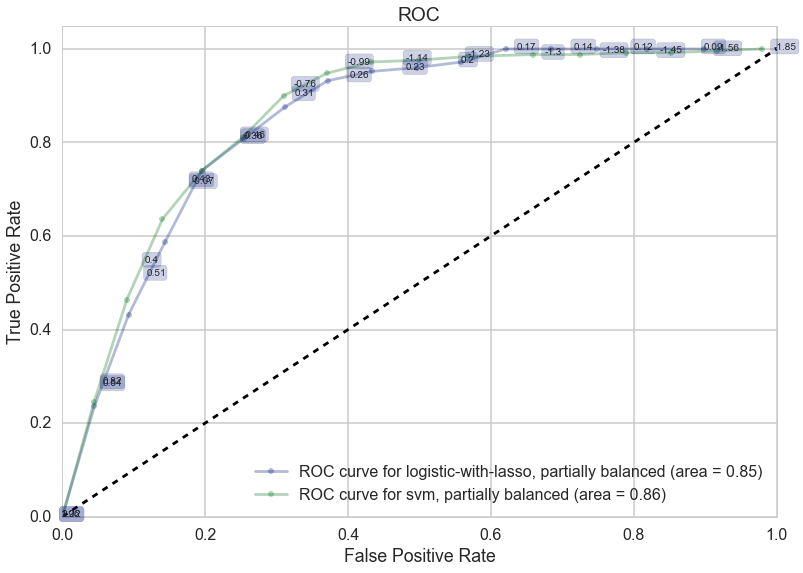

In [427]:
with sns.color_palette("dark"):
    ax= make_roc("logistic-with-lasso, partially balanced",clflog_pb, ytest_pb, Xtest_pb, labe=250, proba=True,  skip=200);
    make_roc("svm, partially balanced",clfsvm_pb, ytestpb, Xtestpb, ax, labe=250, proba=False,  skip=200)